In [1]:
from pydicom import dcmread
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [2]:
path = f'batch/scan5/'
# path = 'intervolume_registered/self_inter/scan5/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.h5'):
        pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'][:,250:550,:])

# original_data = original_data[:,150:650,:]
# def load_data_dcm(path_num,path_all = False):
#     path = path_num
#     pic_paths = []
#     for i in os.listdir(path):
#         if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
#             pic_paths.append(i)
#     pic_paths = natsorted(pic_paths)
#     temp_img = dcmread(path+pic_paths[0]).pixel_array
#     imgs_from_folder = np.zeros((len(pic_paths),*temp_img.shape))
#     for i,j in enumerate(pic_paths):
#         aa = dcmread(path+j)
#         imgs_from_folder[i] = aa.pixel_array
#     imgs_from_folder = imgs_from_folder.astype(np.float32)
#     return imgs_from_folder

In [3]:
# original_data = original_data[:,np.r_[200:500,1300:2250],:]

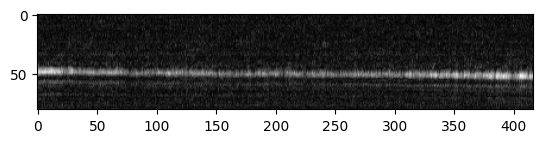

In [8]:
plt.imshow(original_data[30,70:150,:],cmap='gray')

In [9]:
y_err_ncc = []
UP,DOWN = 70,150
for i in tqdm(range(original_data.shape[0])):
    y_err_ncc.append(ncc(original_data[i][UP:DOWN],original_data[300][UP:DOWN])[0])
print(np.mean(y_err_ncc[2:-2]))

100%|██████████| 500/500 [00:00<00:00, 11948.29it/s]

0.6649563895992812


# FLat

In [10]:
mid = 200
flat_err_ncc = []
# UP,DOWN = 50,180
for i in tqdm(range(original_data.shape[2])):
    flat_err_ncc.append(ncc(original_data[:,:mid,i],original_data[:,:mid,300])[0])
print(np.mean(flat_err_ncc[2:-2]))

100%|██████████| 417/417 [00:00<00:00, 608.70it/s]

0.8091694420566793


In [11]:

def mse_fun_tran_flat(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=1)
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=1)

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=1)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=1)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_tran_flat(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[2],1,1))
    for i in tqdm(range(data.shape[2]),desc='tr_all'):
        stat = data[:,UP:DOWN,30][::20].copy()
        temp_img = data[:,UP:DOWN,i][::20].copy()

        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_flat,x0 =(0), bounds=[(-3,3)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(translation=(past_shift*2,0))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)

    return transforms_all


In [12]:
n = original_data.shape[1]

# finding the bright points in all images in standard interference
temp_rotated_data = original_data[:,:n//2,:].transpose(2,1,0)
nn = [np.argmax(np.sum(temp_rotated_data[i],axis=1)) for i in range(temp_rotated_data.shape[0])]
tf_all_nn = np.tile(np.eye(3),(temp_rotated_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(-(nn[0]-nn[i]),0)))
for i in tqdm(range(original_data.shape[2]),desc='warping'):
    original_data[:,:mid,i]  = warp(original_data[:,:mid,i] ,AffineTransform(matrix=tf_all_nn[i]),order=3)

warping: 100%|██████████| 417/417 [00:02<00:00, 165.00it/s]


In [13]:
# UP,DOWN = 140,210
tr_all = ants_all_tran_flat(original_data,UP,DOWN)
for i in tqdm(range(original_data.shape[2]),desc='warping'):
    original_data[:,:mid,i]  = warp(original_data[:,:mid,i] ,AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 417/417 [00:02<00:00, 173.83it/s]


In [14]:
flat_err_ncc = []
for i in tqdm(range(original_data.shape[2])):
    flat_err_ncc.append(ncc(original_data[:,:mid,i],original_data[:,:mid,150])[0])
print(np.mean(flat_err_ncc[2:-2]))

100%|██████████| 417/417 [00:00<00:00, 561.63it/s]

0.8371680235201864


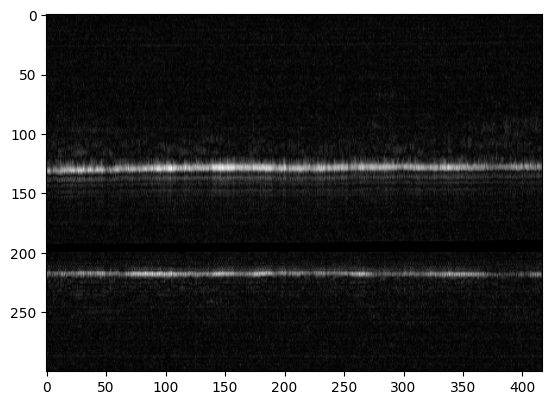

In [43]:
plt.imshow(original_data[10,:,:],cmap='gray')

In [15]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(original_data)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

0it [00:00, ?it/s][ WARN:0@95.313] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.
500it [00:00, 724.83it/s]


# Y-motion

In [44]:
np.argmax(np.sum(original_data[:,UP:DOWN,:],axis=(1,2)))

np.int64(12)

In [45]:

def mse_fun_tran(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(0,-past_shift)),order=3)
    y = warp(y, AffineTransform(translation=(0,past_shift)),order=3)

    warped_x_stat = warp(x, AffineTransform(translation=(0,-shif[0])),order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(0,shif[0])),order=3)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        stat = data[300][UP:DOWN][:,::20].copy()
        temp_img = data[i][UP:DOWN][:,::20].copy()
        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0), bounds=[(-2,2)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(matrix = AffineTransform(translation=(0,past_shift*2)))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)
    return transforms_all


In [46]:
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

warping: 100%|██████████| 500/500 [00:01<00:00, 263.73it/s]


In [47]:

tr_all = ants_all_trans(original_data,UP,DOWN)
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:01<00:00, 283.69it/s]


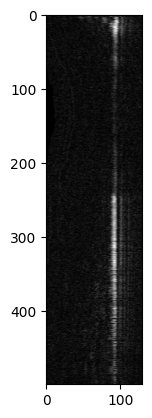

In [48]:
plt.imshow(original_data[:,UP:DOWN,30],cmap='gray')

In [49]:
# os.makedirs('test',exist_ok=True)
# for i,j in tqdm(enumerate(original_data)):
#     cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)


# X-Motion

In [72]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

def ncc1d(array1, array2):
    correlation = np.correlate(array1, array2, mode='valid')
    array1_norm = np.linalg.norm(array1)
    array2_norm = np.linalg.norm(array2)
    if array1_norm == 0 or array2_norm == 0:
        return np.zeros_like(correlation)
    normalized_correlation = correlation / (array1_norm * array2_norm)
    return normalized_correlation

def mse_fun_tran_x(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=3)
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=3)

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=3)

    return (1-ncc(warped_x_stat ,warped_y_mov))

def get_line_shift(line_1d_stat, line_1d_mov,enface_shape):
    # grad_feat = np.argmax(np.abs(np.gradient(line_1d_stat)[5:-5]))+5
    # # print(grad_feat,i)
    # grad_feat = max(20,grad_feat)
    # grad_feat = min(grad_feat,enface_shape-20)
    # st = line_1d_stat[grad_feat-20:grad_feat+20]
    # mv = line_1d_mov[grad_feat-20:grad_feat+20]
    st = line_1d_stat
    mv = line_1d_mov
    past_shift = 0
    for _ in range(10):
        move = minz(method='powell',fun = shift_func,x0 = (0),bounds =[(-5,5)],
                args = (st
                        ,mv
                        ,past_shift))['x']
        past_shift += move[0]
    return past_shift*2

def check_best_warp(stat, mov, value, is_shift_value = False):
    # if is_shift_value:
    err = ncc(stat,warp(mov, AffineTransform(translation=(-value,0)),order=3))
    return err
    # err = ncc(stat,warp(mov, AffineTransform(matrix=value),order=3))
    # return err

def check_multiple_warps(stat_img, mov_img, *args):
    errors = []
    warps = args[0]
    # errors.append(check_best_warp(stat_img, mov_img, warps[0], is_shift_value = False))
    for warp_value in range(len(warps)):
        errors.append(check_best_warp(stat_img, mov_img, warps[warp_value]))
    # print(errors)
    return np.argmax(errors)

import gc

def ants_all_trans_x(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(0,data.shape[0]-1,2),desc='tr_all'):
        stat = data[i][UP:DOWN].copy()
        temp_manual = data[i+1][UP:DOWN].copy()
        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_x,x0 =(0), bounds=[(-5,5)],
                        args = (stat
                                ,temp_manual
                                ,past_shift))['x']

            past_shift += move[0]
        cross_section = -(past_shift*2)
        # temp_tform_manual = AffineTransform(matrix = AffineTransform(translation=(past_shift*2,0)))
        # transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)
        # gc.collect()
        enface_shape = original_data[:,0,:].shape[1]
        enface_line_standard = get_line_shift(data[i,142],data[i+1,142],enface_shape)
        # enface_line_endo = get_line_shift(data[i,800],data[i+1,800],enface_shape)
        enface_line_self = get_line_shift(data[i,216],data[i+1,216],enface_shape)

        all_warps = [cross_section, enface_line_standard, enface_line_self]
        best_warp = check_multiple_warps(data[i], data[i+1], all_warps)

        temp_tform_manual = AffineTransform(translation=(-(all_warps[best_warp]),0))
        transforms_all[i+1] = np.dot(transforms_all[i+1],temp_tform_manual)
        gc.collect()

    return transforms_all


In [71]:
np.argmax(np.sum(original_data[:,190:,30],axis=0))

np.int64(26)

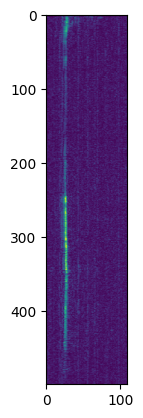

In [76]:
plt.imshow(original_data[:,190:,30])

In [73]:
UP_x,DOWN_x = 80,130
tr_all = ants_all_trans_x(original_data,UP_x,DOWN_x)

tr_all: 100%|██████████| 250/250 [07:25<00:00,  1.78s/it]


In [74]:
gg = original_data.copy()
for i in tqdm(range(1,gg.shape[0],2),desc='warping'):
    gg[i]  = warp(gg[i],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 250/250 [00:01<00:00, 131.51it/s]


In [75]:
folder_save = 'test'
os.makedirs(folder_save,exist_ok=True)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'{folder_save}/'+f'frame_test{i}.PNG',j)

0it [00:00, ?it/s][ WARN:0@1306.938] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.
500it [00:00, 599.21it/s]
